# 수입 우범화물 선별 기초 - XGBoost 모델

# 1. 분석 환경 설정 및 데이터 로딩<a id='id1'></a> 

In [1]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()

In [2]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 한글폰트 적용
plt.rc('font', family='NanumGothicOTF') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

['NanumGothicOTF']


In [3]:
# 수입 데이터 로딩 (가상데이터)
df_org = pd.read_csv('train.csv')

In [4]:
# 분석 차트 그리는 함수 목록

def show_pie_chart(df, col_name):
    colname_survived = survived_crosstab(df, col_name)
    pie_chart(colname_survived)
    return colname_survived

def survived_crosstab(df, col_name):
    '''col_name과 Survived간의 교차도표 생성'''
    feature_survived = pd.crosstab(df[col_name], df['우범여부'])
    feature_survived.columns = feature_survived.columns.map({0:"정상", 1:"우범"})
    return feature_survived

def pie_chart(feature_survived):
    '''
    pie_chart 생성
    pcol, prow = 차트를 출력할 개수. pcol * prow 만큼의 차트 출력 
    '''
    frows, fcols = feature_survived.shape
    pcol = 3
    prow = (frows/pcol + frows%pcol)
    plot_height = prow * 2.5
    plt.figure(figsize=(8, plot_height))

    for row in range(0, frows):
        plt.subplot(prow, pcol, row+1)

        index_name = feature_survived.index[row]
        plt.pie(feature_survived.loc[index_name], labels=feature_survived.loc[index_name].index, autopct='%1.1f%%')
        plt.title("{0}' 우범".format(index_name))

    plt.show()

# 2. 데이터 전처리 <a id='id2'></a>

## 2.1. 전처리 기본(수치형 변수 및 범주형 변수 지정 등)

In [5]:
# 데이터 사이즈 확인
df_org.shape

(76837, 24)

In [6]:
# 데이터 샘플 3개 확인
df_org.sample(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,...,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
62493,18240772,2020.8.5,20,3A8I7,VFM1MLF,NaN,NaN,D,B,11,...,40,4077008,710807000,CN,CN,A,27.0,A,0,0
15946,37145361,2020.2.19,40,7Q31W,6C0YK5O,ANYU5CE,NaN,B,B,15,...,40,2006110,8517699000,HK,CN,C,0.0,A,0,0
50095,33441724,2020.6.22,40,7BOPY,W1TC7ZF,NaN,NaN,C,B,11,...,40,4002001,2106909099,TH,TH,A,8.0,A,0,0


In [7]:
df_org['우범여부'].value_counts()

0    59265
1    17572
Name: 우범여부, dtype: int64

In [8]:
df_org['핵심적발'].value_counts()

0    59265
2     9049
1     8523
Name: 핵심적발, dtype: int64

In [9]:
# 불필요한 변수 삭제
del df_org['검사결과코드']
del df_org['핵심적발']
del df_org['신고인부호']
del df_org['수입자부호']
del df_org['해외거래처부호']

In [10]:
df_org.columns

Index(['신고번호', '신고일자', '통관지세관부호', '특송업체부호', '수입통관계획코드', '수입신고구분코드', '수입거래구분코드',
       '수입종류코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '운송수단유형코드', '반입보세구역부호',
       'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부'],
      dtype='object')

## 신고일자

- 월로 변경

In [11]:
## 신고일자 -> 월로 변경

df_org['신고일자'] = pd.to_datetime(df_org['신고일자'])
df_org['신고일자(월)'] = df_org['신고일자'].dt.month
df_org['신고일자(월)'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 신고일자(월), dtype: int64

In [12]:
del df_org['신고일자']

<ipython-input-4-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


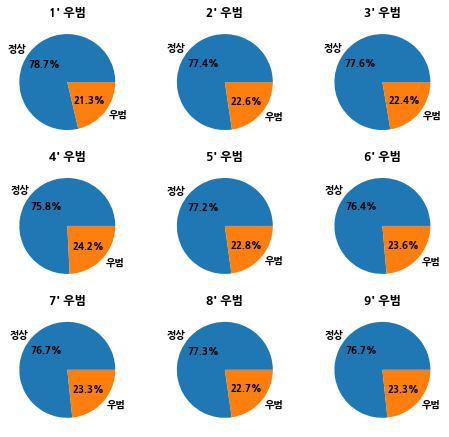

우범여부,정상,우범
신고일자(월),,
1,8121,2203
2,6901,2020
3,7269,2093
4,5972,1908
5,6209,1835
6,6099,1885
7,6658,2027
8,6100,1794
9,5936,1807


In [15]:
c = show_pie_chart(df_org, '신고일자(월)')
c

In [16]:
# 범주형 변수 지정
discrete_columns = ['신고일자(월)',  '통관지세관부호',
                    '특송업체부호', '수입통관계획코드', 
                    '수입신고구분코드', '수입거래구분코드',
                    '수입종류코드','징수형태코드', 
                    '운송수단유형코드', '반입보세구역부호', 
                    'HS10단위부호', '적출국가코드', 
                    '원산지국가코드', '관세율구분코드']

# 범주형 변수들을 문자열로 지정 ('object' -> 'string')
for var in discrete_columns:
    df_org[var] = df_org[var].astype(str)

In [17]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고번호      76837 non-null  int64  
 1   통관지세관부호   76837 non-null  object 
 2   특송업체부호    76837 non-null  object 
 3   수입통관계획코드  76837 non-null  object 
 4   수입신고구분코드  76837 non-null  object 
 5   수입거래구분코드  76837 non-null  object 
 6   수입종류코드    76837 non-null  object 
 7   징수형태코드    76837 non-null  object 
 8   신고중량(KG)  76837 non-null  float64
 9   과세가격원화금액  76837 non-null  float64
 10  운송수단유형코드  76837 non-null  object 
 11  반입보세구역부호  76837 non-null  object 
 12  HS10단위부호  76837 non-null  object 
 13  적출국가코드    76837 non-null  object 
 14  원산지국가코드   76837 non-null  object 
 15  관세율구분코드   76837 non-null  object 
 16  관세율       76837 non-null  float64
 17  우범여부      76837 non-null  int64  
 18  신고일자(월)   76837 non-null  object 
dtypes: float64(3), int64(2), object(14)
memory usage: 11.1+ MB


In [18]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율', '우범여부']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)', '과세가격원화금액']:
    df_org[var] = df_org[var].apply(lambda x: np.log1p(x))

In [19]:
df_org.head(5)

,신고번호,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부,신고일자(월)
0,57298928,121,TQ18AK,D,B,15,23,43,4.844187,8.593963,10,2106003,8481900000,US,US,A,8.0,1,1
1,85092852,30,nan,C,B,11,21,11,10.303820,13.258812,40,4077010,2106909099,US,US,A,8.0,0,1
2,63014158,20,nan,D,B,11,21,18,10.067242,10.862759,40,4077007,6307909000,US,US,A,10.0,0,1
3,40175917,40,nan,C,B,94,21,43,9.429564,14.388527,40,4077106,6505009090,CN,CN,A,8.0,0,1
4,11602631,30,nan,C,B,11,21,43,9.661015,15.987683,40,2006075,6204320000,CN,CN,FCN1,5.2,1,1


## 2.2. 훈련데이터와 테스트데이터 분리 및 범주형 변수 전처리 

In [20]:
# 날짜 순에 따라 90:10 으로 훈련 및 테스트 데이터 분리
df_org_train = df_org.iloc[:int(len(df_org)*0.9), :]
df_org_test = df_org.iloc[int(len(df_org)*0.9):, :]

In [21]:
# 데이터 사이즈 확인
print(df_org_train.shape, df_org_test.shape)

(69153, 19) (7684, 19)


In [22]:
df_org.columns

Index(['신고번호', '통관지세관부호', '특송업체부호', '수입통관계획코드', '수입신고구분코드', '수입거래구분코드',
       '수입종류코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '운송수단유형코드', '반입보세구역부호',
       'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부', '신고일자(월)'],
      dtype='object')

In [23]:
df_org.shape

(76837, 19)

In [24]:
# 이 코드는 문제 : categorical 변수를 단순히 숫자로 mapping

# 범주형 변수 전처리 1단계: label encoding --> 각 범주형 변수가 갖는 클래스에 고유의 식별번호 부여
# 예) 수입자 상호: AAABB -> 1, 가나다라 -> 2, ...

label_encoding_ref = {}
for var in discrete_columns:
    label_encoding_ref[var] = {code: i+1 for i, code in enumerate(df_org_train[var].unique())}
    # 0 padding for unseen data in test
    # print(label_encoding_ref[var])
    df_org_train[var] = [label_encoding_ref[var][x] for x in df_org_train[var]]
    df_org_test[var] = [label_encoding_ref[var].get(x,0) for x in df_org_test[var]]

df_org_train.reset_index(drop=True, inplace=True)
df_org_test.reset_index(drop=True, inplace=True)

<ipython-input-24-77cfbc4bf424>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org_train[var] = [label_encoding_ref[var][x] for x in df_org_train[var]]
<ipython-input-24-77cfbc4bf424>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org_test[var] = [label_encoding_ref[var].get(x,0) for x in df_org_test[var]]


In [25]:
# 트레인데이터 샘플 확인
df_org_train.sample(3)

,신고번호,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부,신고일자(월)
36117,55574882,2,21,2,2,4,2,2,7.915823,11.942319,2,47,4,2,2,1,8.0,1,4
63765,19630676,4,2,2,1,2,2,1,9.708044,12.027974,2,40,25,2,2,1,8.0,0,8
42341,69514537,3,2,1,1,2,2,2,8.628574,12.534152,2,37,301,17,16,8,0.0,0,5


In [26]:
# 테스트데이터 샘플 확인
df_org_test.sample(3)

,신고번호,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부,신고일자(월)
4405,33141931,4,60,1,1,4,5,3,8.198282,12.082910,1,82,135,2,2,7,9.1,1,9
3086,13367135,3,14,1,1,2,4,2,8.862399,11.966458,1,2,2,1,1,1,8.0,0,9
610,60320161,11,2,2,1,2,2,2,8.699015,14.811303,1,195,1495,36,39,32,0.0,0,9


In [27]:
# 아까 숫자로 변환시킨 것에서 ->one-hot-encoding
# 예) A,B,C 3개의 클래스가 있는 범주형 변수를 다음과 같이 변환
# A -> [1,0,0] / B -> [0,1,0] / C -> [0,0,1]

# 원핫인코더 로딩
from sklearn.preprocessing import  OneHotEncoder
# 원핫인코더 활성화
xgbohe = OneHotEncoder(categories="auto", handle_unknown='ignore')
# 훈련데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_train_cat = xgbohe.fit_transform(df_org_train[discrete_columns])
df_org_train_cat = pd.DataFrame(df_org_train_cat.toarray(), 
                                columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_train_num = df_org_train[numeric_columns]

# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_train = pd.concat([df_org_train_num, df_org_train_cat], axis=1)

In [28]:
# 전체 정보 확인
df_org_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69153 entries, 0 to 69152
Columns: 3375 entries, 신고중량(KG) to 관세율구분코드_35
dtypes: float64(3374), int64(1)
memory usage: 1.7 GB


In [29]:
# 훈련데이터 샘플 확인
df_org_train.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자(월)_1,신고일자(월)_2,신고일자(월)_3,신고일자(월)_4,신고일자(월)_5,신고일자(월)_6,...,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,4.844187,8.593963,8.0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_org_train.columns[40:60]

Index(['통관지세관부호_28', '통관지세관부호_29', '통관지세관부호_30', '통관지세관부호_31', '통관지세관부호_32',
       '통관지세관부호_33', '통관지세관부호_34', '통관지세관부호_35', '통관지세관부호_36', '통관지세관부호_37',
       '통관지세관부호_38', '통관지세관부호_39', '통관지세관부호_40', '특송업체부호_1', '특송업체부호_2',
       '특송업체부호_3', '특송업체부호_4', '특송업체부호_5', '특송업체부호_6', '특송업체부호_7'],
      dtype='object')

In [32]:
# 테스트데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_test_cat = xgbohe.transform(df_org_test[discrete_columns])
df_org_test_cat = pd.DataFrame(df_org_test_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_test_num = df_org_test[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_test = pd.concat([df_org_test_num, df_org_test_cat], axis=1)

In [33]:
# 테스트데이터 샘플 확인
df_org_test.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자(월)_1,신고일자(월)_2,신고일자(월)_3,신고일자(월)_4,신고일자(월)_5,신고일자(월)_6,...,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,8.63145,16.057899,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# 모델예측 대상인 우범여부 변수 분리
org_train_y = df_org_train.pop('우범여부')
org_test_y = df_org_test.pop('우범여부')

In [35]:
# 훈련데이터와 테스트데이터에서 우범건수 비교
from collections import Counter
cnt_train = Counter(org_train_y)
cnt_test = Counter(org_test_y)

print(f"훈련  데이터 비우범건수: {cnt_train[0]}, 훈련  데이터 우범건수: {cnt_train[1]}")
print(f"테스트데이터 비우범건수: {cnt_test[0]}, 테스트데이터 우범건수: {cnt_test[1]}")

훈련  데이터 비우범건수: 53371, 훈련  데이터 우범건수: 15782
테스트데이터 비우범건수: 5894, 테스트데이터 우범건수: 1790


# 3. 모델 생성 및 훈련 <a id='id3'></a>

## 3.1. XGBoost 모델 생성

In [36]:
# XGBoost 모델 생성
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

## 3.2. XGBoost 모델 훈련

In [37]:
# 모델 활성화 및 설정
xgb_clf = XGBClassifier(n_estimators=10, max_depth=4,n_jobs=-1) #
# 모델 훈련 시 성능평가 데이터 설정 (별도의 성능평가 데이터를 구성할 수도 있으나, 여기서는 그냥 테스트데이터를 사용)
eval_set = [(df_org_train, org_train_y), (df_org_test, org_test_y)]
# 모델 훈련 (training/fitting)
xgb_clf.fit(df_org_train, org_train_y, eval_metric=["logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.59089	validation_1-logloss:0.59171
[1]	validation_0-logloss:0.53650	validation_1-logloss:0.53771
[2]	validation_0-logloss:0.50407	validation_1-logloss:0.50506
[3]	validation_0-logloss:0.48384	validation_1-logloss:0.48498
[4]	validation_0-logloss:0.47122	validation_1-logloss:0.47304
[5]	validation_0-logloss:0.46233	validation_1-logloss:0.46438
[6]	validation_0-logloss:0.45660	validation_1-logloss:0.45936
[7]	validation_0-logloss:0.45012	validation_1-logloss:0.45297
[8]	validation_0-logloss:0.44623	validation_1-logloss:0.44882
[9]	validation_0-logloss:0.44121	validation_1-logloss:0.44398


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
from keras.utils.vis_utils import plot_model

ModuleNotFoundError: No module named 'keras'

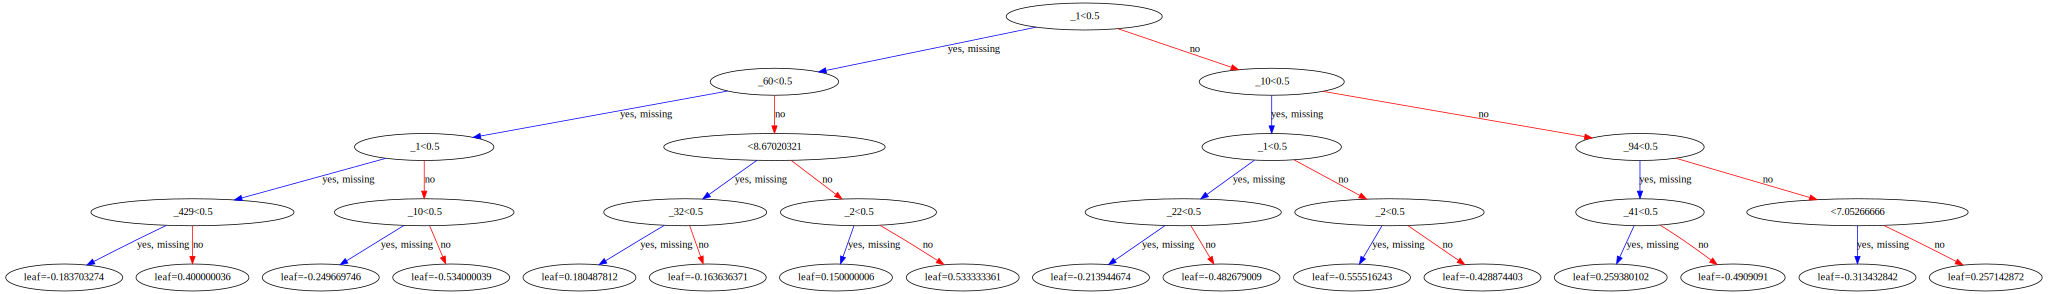

In [32]:
# 의사결정 트리 중 첫번째 트리 시각화
import xgboost as xgb
xgb.to_graphviz(booster = xgb_clf, num_trees=0)

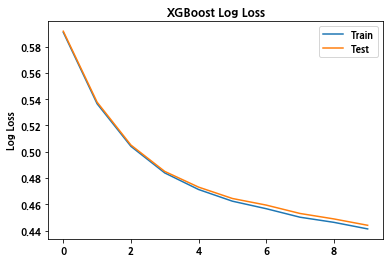

In [39]:
# 모델 성능 시각화

from matplotlib import pyplot
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
#pyplot.show()
plt.savefig('XGBoost Log Loss.png')

# 4. 우범화물 예측 및 모델 성능 평가 <a id='id4'></a>

## 4.1. XGBoost 모델 예측

In [40]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb_clf.predict_proba(df_org_test)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(org_test_y, test_pred)
print(xgb_auc)

------Evaluating xgboost model------
0.7992347581955326


## 4.2. 모델 예측 성능 평가

In [41]:
# 검사율에 따른 우범예측 함수 생성

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud >= threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud >= threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [42]:
# 검사율에 따른 우범예측 
basic_performance = inspection_performance(test_pred, org_test_y.astype(float))

In [43]:
# 검사율 1~10% 지정 시 Precision 및 Recall 분석
# Precision (적중률) = (검사선별된 우범건수)/(검사선별 건수)
# Recall (적발률) = (검사선별된 우범건수) / (전체 우범건수)
basic_performance.iloc[range(99,89,-1),:]

,Inspect_Rate,Precision,Recall
99,1,0.805195,0.034637
98,2,0.753012,0.069832
97,3,0.723404,0.094972
96,4,0.702265,0.121229
95,5,0.697500,0.155866
94,6,0.678959,0.174860
93,7,0.649374,0.202793
92,8,0.645631,0.222905
91,9,0.631054,0.247486
90,10,0.627376,0.276536


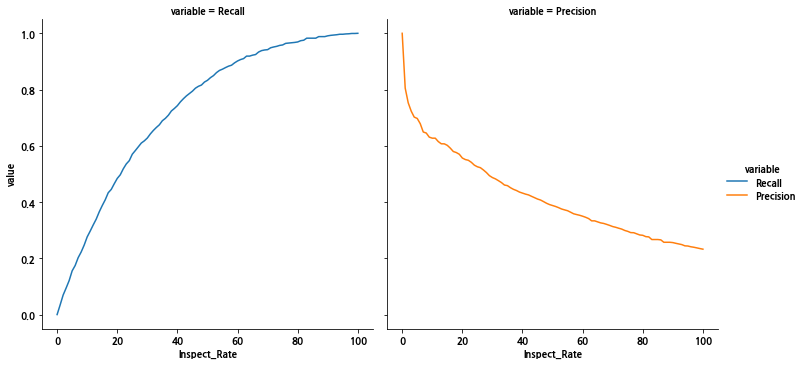

In [44]:
# 검사선별률에 따른 적중률 및 적발률 시각화
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")
plt.savefig('recall & precision.png')


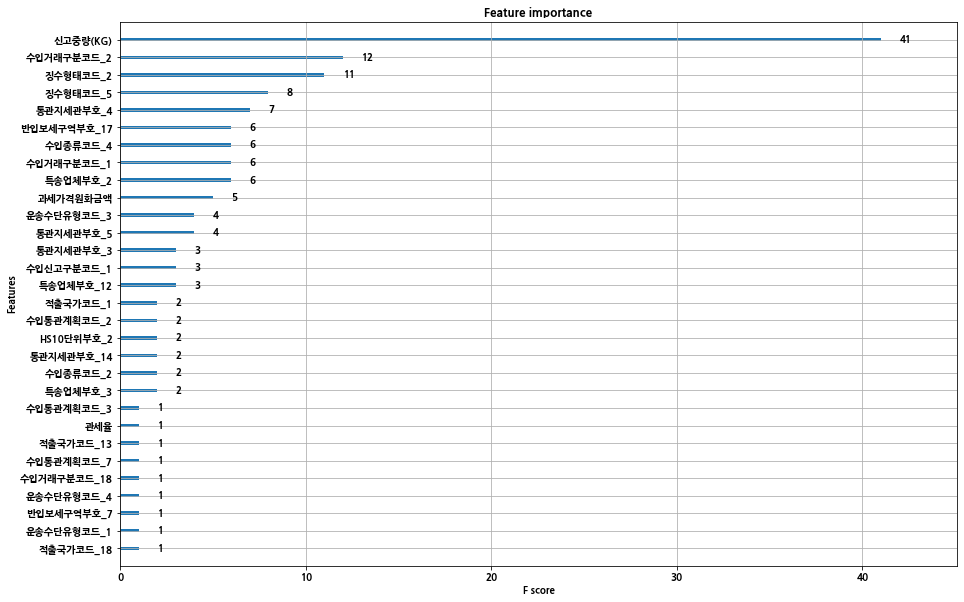

In [47]:
# 모델에 기여도가 높은 변수 시각화
from xgboost import plot_importance
plt.rcParams["font.family"] = 'NanumGothicOTF'
plt.rcParams["figure.figsize"] = (15,10)
plot_importance(xgb_clf, max_num_features=30)
plt.show()

In [48]:
precision = 0.805195
recall = 0.034637
f1_score = 2 * precision * recall / (precision + recall)
print(f1_score)

0.0664169481872565


In [49]:
precision = 0.710000
recall = 0.076840
f1_score = 2 * precision * recall / (precision + recall)
print(f1_score)

0.13867215698235982


In [40]:
# 모델 종료 시간 확인
end = time.time()
# 모델 구동 시간 계산
print(f"모델구동시간 : {end-start} sec.")

모델구동시간 : 50.08880972862244 sec.
